<table style="width: 100%;"> <tr> <td style="width: 20%; vertical-align: top;"> <img src="https://upload.wikimedia.org/wikipedia/commons/archive/f/fb/20161010213812%21Escudo-UdeA.svg" alt="UdeA" height="150px"> </td> <td style="width: 80%; padding-left: 20px;"> <strong style="font-size: 30px;">MODELO DE REDES NEURONALES CONVOLUCIONALES PARA UN SISTEMA DE CLASIFICACIÓN CON IMÁGENES DE RESONANCIA MAGNÉTICA </strong><br><br> <span style="font-size: 30px;"> Luisa Fernanda Alzate Cuartas <br> Juan Camilo Henao Caro<br>Isabella Mendez Hoyos<br> Fernando Antonio Piñeres Ramos </span> </td> </tr> </table>

#### IMPORTE E INSTALACIÓN DE LIBRERÍAS

In [1]:
# Conectar con Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Instalación de librerías.
!pip install optuna

In [3]:
import sys #Interactuar de manera directa con el intérprete de Python
import os #Se utiliza para interactuar con el sistema operativo
path = '/content/drive/MyDrive/operaciones' # Configura el entorno para trabajar con archivos en Google Drive
sys.path.append(path) # Permite importar módulos desde esta ruta.
os.chdir(path) # Cambia el directorio de trabajo actual

In [4]:
# Importe de librerías.
import optuna #Para el ajuste de hiperparámetros.
import numpy as np  #Manipulación de estructuras de datos matriciales y funciones matemáticas de alto nivel.
import pandas as pd #Manipulación y transformación de datos.
import tensorflow as tf # Permite crear y entrenar redes neuronales, procesar datos y gestionar modelos para diversas aplicaciones.
from sklearn import metrics #. Funciones de puntuación, métricas de rendimiento, métricas por pares y cálculos de distancia.
from sklearn.metrics import roc_auc_score #Calcular el área bajo la curva característica operativa del receptor (ROC AUC) a partir de los puntajes de predicción.
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Permite expandir los datos de entrenamiento de la imagen, mediante el uso de transformaciones como rotaciones aleatorias, transformaciones de corte, cambios, zooms y giros, en los datos de imagen disponibles.
from tensorflow.keras.models import Sequential #Apropiado para una pila simple de capas donde cada capa tiene exactamente un tensor de entrada y un tensor de salida .
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization #Para construir una red neuronal convolucional compleja que pueda procesar y aprender de datos de imágenes, textos secuenciales, o cualquier otro dato que pueda ser representado en una cuadrícula 2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint ### Importación de Callbacks para el Control del Entrenamiento
#Los Callbacks son herramientas poderosas que nos permiten monitorear y controlar el proceso de entrenamiento del modelo, ayudando a optimizar el rendimiento y la eficiencia.
from sklearn.utils import shuffle #´Para que el modelo no aprenda de un orden específico y para asegurar que el entrenamiento sea más robusto.
import joblib #Para guardar y cargar modelos de machine learning.
#Guardar el modelo una vez entrenado para no tener que entrenarlo de nuevo cada vez que lo necesites usar.
import random
from tensorflow.keras.utils import to_categorical

#### LECTURA DEL CONJUNTO DE IMÁGENES

In [5]:
#Cargar el conjunto de datos(imágenes) a usar para el modelo.
x_train = joblib.load('/content/drive/MyDrive/operaciones/salidas/data_final/x_train.pkl')
y_train = joblib.load('/content/drive/MyDrive/operaciones/salidas/data_final/y_train.pkl')
x_test = joblib.load('/content/drive/MyDrive/operaciones/salidas/data_final/x_test.pkl')
y_test = joblib.load('/content/drive/MyDrive/operaciones/salidas/data_final/y_test.pkl')
x_val = joblib.load('/content/drive/MyDrive/operaciones/salidas/data_final/x_val.pkl')
y_val = joblib.load('/content/drive/MyDrive/operaciones/salidas/data_final/y_val.pkl')

#### EXPLORACIÓN DEL CONJUNTO DE DATOS(IMÁGENES)

In [6]:
display(x_train.shape)
display(y_train.shape)
display(x_test.shape)
display(y_test.shape)
display(x_val.shape)
display(y_val.shape)

(5553, 160, 160, 3)

(5553,)

(695, 160, 160, 3)

(695,)

(694, 160, 160, 3)

(694,)

#### ESCALADO DEL CONJUNTO DE DATOS.

In [7]:
#### Escalar ######################
x_train=x_train.astype('float32') ## para poder escalarlo
x_test=x_test.astype('float32') ## para poder escalarlo
x_train.max()
x_train.min()


x_train /=255 ### escalarlo para que quede entre 0 y 1, con base en el valor máximo
x_test /=255

###### verificar tamaños

x_train.shape
x_test.shape

np.prod(x_train[1].shape) ## cantidad de variables por imagen

display(np.unique(y_train, return_counts=True))
display(np.unique(y_test, return_counts=True))

(array([0, 1, 2, 3]), array([1232, 1316, 1600, 1405]))

(array([0, 1, 2, 3]), array([154, 165, 200, 176]))

#### DATA AUGMENTATION

In [8]:

# Crear el generador de augmentación
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest' #se rellena los pixeles vacios con el pixel mas cercano
)

# Función para balancear un conjunto de datos (train o test)
def balance_dataset(x, y, datagen):
    classes, counts = np.unique(y, return_counts=True)
    max_count = max(counts)
    x_aug = []
    y_aug = []

    for c in classes:
        x_class = x[y == c]
        y_class = y[y == c]
        n_samples_needed = max_count - len(x_class)

        # Agregar los datos originales
        x_aug.extend(x_class)
        y_aug.extend(y_class)

        # Generar muestras augmentadas si es necesario
        if n_samples_needed > 0:
            # Reshape para que datagen.flow funcione correctamente con un solo lote
            x_class_reshaped = np.expand_dims(x_class, axis=1)
            y_class_reshaped = np.expand_dims(y_class, axis=1)

            gen = datagen.flow(x_class, y_class, batch_size=1)
            for _ in range(n_samples_needed):
                x_gen, y_gen = next(gen)
                x_aug.append(x_gen[0])
                y_aug.append(y_gen[0])

    # Convertir a arrays numpy
    x_balanced = np.array(x_aug)
    y_balanced = np.array(y_aug)

    # Barajar (opcional pero recomendable)
    x_balanced, y_balanced = shuffle(x_balanced, y_balanced, random_state=42)

    return x_balanced, y_balanced

# Aumentar el conjunto de entrenamiento
x_train_balanced, y_train_balanced = balance_dataset(x_train, y_train, datagen)

# Aumentar el conjunto de prueba
x_test_balanced, y_test_balanced = balance_dataset(x_test, y_test, datagen)

# Guardar los conjuntos balanceados si deseas
joblib.dump(x_train_balanced, '/content/drive/MyDrive/operaciones/salidas/data_final/x_train_balanced.pkl')
joblib.dump(y_train_balanced, '/content/drive/MyDrive/operaciones/salidas/data_final/y_train_balanced.pkl')
joblib.dump(x_test_balanced, '/content/drive/MyDrive/operaciones/salidas/data_final/x_test_balanced.pkl')
joblib.dump(y_test_balanced, '/content/drive/MyDrive/operaciones/salidas/data_final/y_test_balanced.pkl')

# Verificar las distribuciones después del balanceo
display(np.unique(y_train_balanced, return_counts=True))
display(np.unique(y_test_balanced, return_counts=True))

(array([0, 1, 2, 3]), array([1600, 1600, 1600, 1600]))

(array([0, 1, 2, 3]), array([200, 200, 200, 200]))

In [9]:
display(x_train_balanced.shape)
display(y_train_balanced.shape)
display(x_test_balanced.shape)
display(y_test_balanced.shape)
display(x_val.shape)
display(y_val.shape)

(6400, 160, 160, 3)

(6400,)

(800, 160, 160, 3)

(800,)

(694, 160, 160, 3)

(694,)

In [10]:
y_train_balanced = to_categorical(y_train_balanced, num_classes=4)
y_test_balanced = to_categorical(y_test_balanced, num_classes=4)

In [11]:
y_train_balanced.shape

(6400, 4)

#### MODELO DE REDES NEURONALES CONVOLUSIONALES

##### MODELO BASE
---

In [25]:
# Función objetivo para utilizar Optuna con API funcional
def objective(trial):
    # Hiperparámetros
    dropout_rate = trial.suggest_float('dropout_rate', 0.05, 0.2, step=0.05)
    reg_strength = trial.suggest_float('reg_strength', 0.0001, 0.0005, step=0.0001)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd'])

    # Modelo funcional CNN
    inputs = tf.keras.Input(shape=x_train_balanced.shape[1:])
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                               kernel_regularizer=tf.keras.regularizers.l2(reg_strength))(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                               kernel_regularizer=tf.keras.regularizers.l2(reg_strength),
                               name='last_conv')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(reg_strength))(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Optimizador
    opt = tf.keras.optimizers.Adam(learning_rate=0.001) if optimizer_name == 'adam' else tf.keras.optimizers.SGD(learning_rate=0.001)

    # Compilar
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=[tf.keras.metrics.AUC(name='auc')])

    # Callback
    checkpoint3 = ModelCheckpoint(
        filepath='best_model_hiperparametros.keras',
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    # Entrenamiento
    model.fit(
        x_train_balanced, y_train_balanced,
        epochs=5,
        validation_data=(x_test_balanced, y_test_balanced),
        batch_size=100,
        verbose=0,
        callbacks=[checkpoint3]
    )

    # Cargar mejor modelo
    model_win = tf.keras.models.load_model('best_model_hiperparametros.keras')

    # Evaluación
    y_pred_prob = model_win.predict(x_test_balanced)
    auc = roc_auc_score(y_test_balanced, y_pred_prob)
    trial.set_user_attr("model", model_win)

    return auc


In [12]:
# =====================
# 2. MODELO FUNCIONAL CNN
# =====================

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'


inputs = tf.keras.Input(shape=x_train_balanced.shape[1:])
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='last_conv')(x)  # IMPORTANTE para Grad-CAM
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

cnn_model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [13]:
# =====================
# 3. COMPILACIÓN
# =====================
cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['AUC']
)

cnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 158, 158, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 79, 79, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv (Conv2D)              │ (None, 77, 77, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46208)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,957,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,962,724 (11.30 MB)

 Trainable params: 2,962,724 (11.30 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_AUC',
    patience=3,
    mode='max',
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_AUC',
    mode='max',
    save_best_only=True,
    verbose=1
)

history = cnn_model.fit(
    x_train_balanced, y_train_balanced,
    validation_data=(x_test_balanced, y_test_balanced),
    epochs=15,
    callbacks=[early_stopping, model_checkpoint],
    batch_size=100
)

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.7809 - loss: 1.0667
Epoch 1: val_AUC improved from -inf to 0.94349, saving model to best_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - AUC: 0.7825 - loss: 1.0625 - val_AUC: 0.9435 - val_loss: 0.5700
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.9660 - loss: 0.4405
Epoch 2: val_AUC improved from 0.94349 to 0.96088, saving model to best_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - AUC: 0.9661 - loss: 0.4400 - val_AUC: 0.9609 - val_loss: 0.4859
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.9820 - loss: 0.3161
Epoch 3: val_AUC improved from 0.96088 to 0.96959, saving model to best_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - AUC: 0.9820 - loss: 0.3157 - val_AUC: 0.9696 - val_loss: 0.4293
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.9898 - loss: 0.2376
Epoch 4: val_AUC did not improve from 0.96959
64/64 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - AUC: 0.9898 - loss: 0.2373 - val_

In [15]:
import matplotlib.pyplot as plt

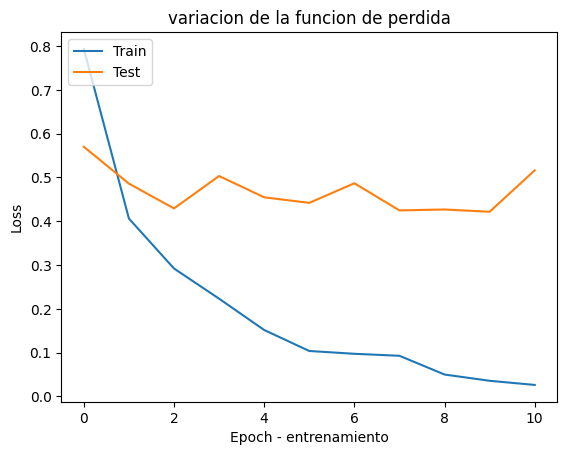

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('variacion de la funcion de perdida')
plt.ylabel('Loss')
plt.xlabel('Epoch - entrenamiento')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

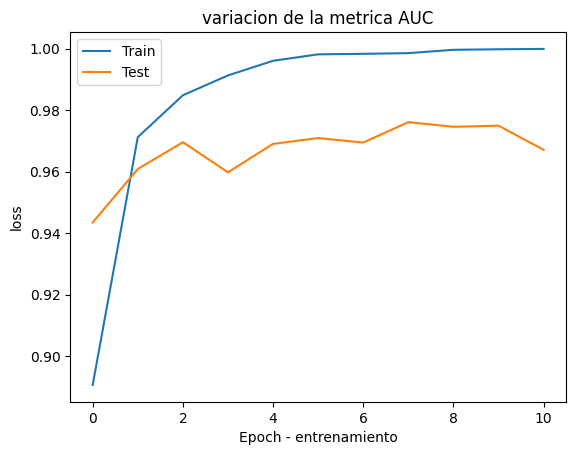

In [17]:
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('variacion de la metrica AUC')
plt.ylabel('loss')
plt.xlabel('Epoch - entrenamiento')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### XAI
---



Este bloque de código implementa Grad-CAM (Gradient-weighted Class Activation Mapping), una técnica de
Inteligencia Artificial Explicable (XAI) utilizada para modelos de visión por computador, como redes neuronales
convolucionales (CNN). Grad-CAM genera un mapa de calor (heatmap) que resalta las regiones de una imagen
que más influyen en la predicción del modelo. Esto permite visualizar "dónde está mirando" la red neuronal
cuando clasifica una imagen, lo cual es especialmente útil en contextos como el diagnóstico médico, donde es
importante entender y confiar en la decisión automática. Al superponer el heatmap sobre la imagen original,
obtenemos una explicación visual de la predicción, lo que convierte este enfoque en una herramienta poderosa
para interpretar modelos de aprendizaje profundo.






In [18]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Definir las clases que tienes
class_names = ['glioma', 'meningioma', 'pituitary', 'notumor']

# Función para generar Grad-CAM (supongo que ya la tienes, si no puedo ayudarte a armarla)
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Función para superponer heatmap a la imagen
def superimpose_heatmap(img, heatmap, alpha=0.4):
    import cv2
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap_color * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    return superimposed_img

# Ejemplo para mostrar imágenes y predicciones con Grad-CAM
def show_images_with_gradcam(model, dataset, start_idx, end_idx, last_conv_layer_name):
    for i in range(start_idx, end_idx):
        img = dataset[i]
        img_array = np.expand_dims(img, axis=0)  # Expandir dims para batch
        preds = model.predict(img_array)
        pred_class = np.argmax(preds[0])
        pred_label = class_names[pred_class]

        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_class)
        img_uint8 = (img * 255).astype(np.uint8)  # Si tu imagen está en [0,1]
        superimposed_img = superimpose_heatmap(img_uint8, heatmap)

        plt.figure(figsize=(10,4))

        plt.subplot(1, 3, 1)
        plt.title('Imagen Original')
        plt.imshow(img)
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title('Heatmap Grad-CAM')
        plt.imshow(heatmap, cmap='jet')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title(f'Imagen + Heatmap\nPredicción: {pred_label}')
        plt.imshow(superimposed_img)
        plt.axis('off')

        plt.show()

# Usar la función (por ejemplo para imágenes de índice 8 a 12)
show_images_with_gradcam(cnn_model, x_test_balanced, 80, 95, last_conv_layer_name='conv2d')


Output hidden; open in https://colab.research.google.com to view.

##### MODELO CNN CON REGULARIZACION
---

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
import random
import os

# ---------- SEMILLA PARA REPRODUCIBILIDAD ----------
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# ---------- HIPERPARÁMETROS ----------
reg_strength = 0.001
dropout_rate = 0.1
input_shape = x_train_balanced.shape[1:]

# ---------- MODELO FUNCIONAL CON L2 + DROPOUT ----------
inputs = tf.keras.Input(shape=input_shape)

x = tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu',
                           kernel_regularizer=regularizers.l2(reg_strength))(inputs)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)

x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu',
                           kernel_regularizer=regularizers.l2(reg_strength))(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu',
                          kernel_regularizer=regularizers.l2(reg_strength))(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)

outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

cnn_model2 = tf.keras.Model(inputs=inputs, outputs=outputs)

In [20]:
# ---------- COMPILACIÓN ----------
cnn_model2.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[tf.keras.metrics.AUC(name='AUC')]
)

cnn_model2.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 158, 158, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 79, 79, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 79, 79, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 77, 77, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 38, 38, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 38, 38, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 46208)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     2,957,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,962,724 (11.30 MB)

 Trainable params: 2,962,724 (11.30 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:

# ---------- CHECKPOINT ----------

from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_AUC',
    patience=3,
    mode='max',
    restore_best_weights=True
)



checkpoint2 = ModelCheckpoint(
    filepath='best_model_l2_dropout.keras',
    monitor='val_AUC',
    mode='max',
    save_best_only=True,
    verbose=1
)

# ---------- ENTRENAMIENTO ----------
history2 = cnn_model2.fit(
    x_train_balanced, y_train_balanced,
    batch_size=100,
    epochs=7,
    validation_data=(x_test_balanced, y_test_balanced),
    callbacks=[checkpoint2,early_stopping]
)

Epoch 1/7
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.9349 - loss: 0.7364
Epoch 1: val_AUC improved from -inf to 0.95429, saving model to best_model_l2_dropout.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - AUC: 0.9351 - loss: 0.7357 - val_AUC: 0.9543 - val_loss: 0.6357
Epoch 2/7
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.9625 - loss: 0.5833
Epoch 2: val_AUC improved from 0.95429 to 0.96594, saving model to best_model_l2_dropout.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - AUC: 0.9625 - loss: 0.5832 - val_AUC: 0.9659 - val_loss: 0.5693
Epoch 3/7
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.9695 - loss: 0.5394
Epoch 3: val_AUC did not improve from 0.96594
64/64 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - AUC: 0.9695 - loss: 0.5393 - val_AUC: 0.9647 - val_loss: 0.5805
Epoch 4/7
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.9789 - loss: 0.4842
Epoch 4: val_AUC improved from 0.96594 to 0.96941, saving model to best_model_l2_dropout.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - AUC:

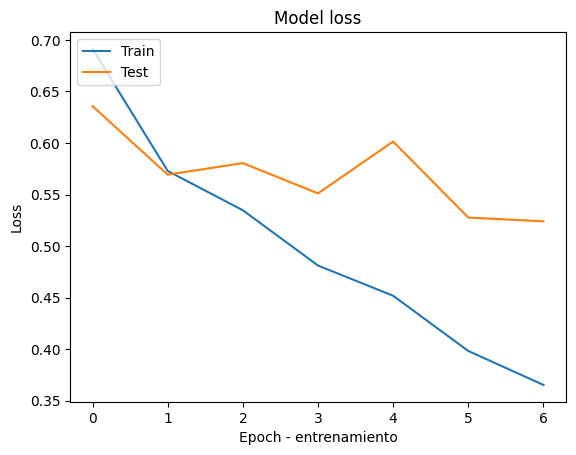

In [23]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch - entrenamiento')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


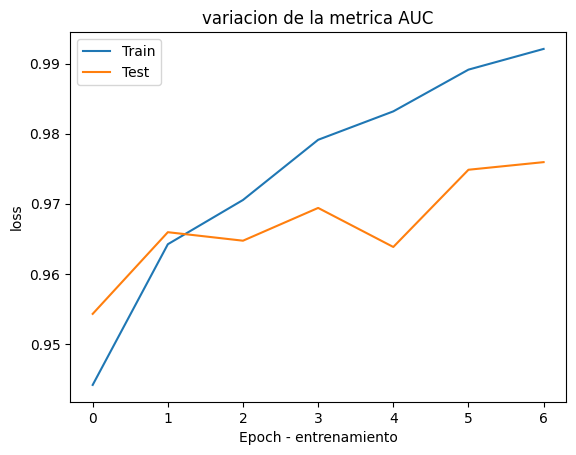

In [24]:
plt.plot(history2.history['AUC'])
plt.plot(history2.history['val_AUC'])
plt.title('variacion de la metrica AUC')
plt.ylabel('loss')
plt.xlabel('Epoch - entrenamiento')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

##### MODELO CON AJUSTES DE HIPERPARAMETROS
---

In [26]:
# Función objetivo para utilizar Optuna con API funcional
def objective(trial):
    # Hiperparámetros
    dropout_rate = trial.suggest_float('dropout_rate', 0.05, 0.2, step=0.05)
    reg_strength = trial.suggest_float('reg_strength', 0.0001, 0.0005, step=0.0001)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd'])

    # Modelo funcional CNN
    inputs = tf.keras.Input(shape=x_train_balanced.shape[1:])
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                               kernel_regularizer=tf.keras.regularizers.l2(reg_strength))(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                               kernel_regularizer=tf.keras.regularizers.l2(reg_strength),
                               name='last_conv')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(reg_strength))(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Optimizador
    opt = tf.keras.optimizers.Adam(learning_rate=0.001) if optimizer_name == 'adam' else tf.keras.optimizers.SGD(learning_rate=0.001)

    # Compilar
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=[tf.keras.metrics.AUC(name='auc')])

    # Callback

    early_stopping = EarlyStopping(
    monitor='val_AUC',
    patience=3,
    mode='max',
    restore_best_weights=True
)


    checkpoint3 = ModelCheckpoint(
        filepath='best_modelo_hiperparametros.keras',
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    # Entrenamiento
    model.fit(
        x_train_balanced, y_train_balanced,
        epochs=10,
        validation_data=(x_test_balanced, y_test_balanced),
        batch_size=100,
        verbose=0,
        callbacks=[checkpoint3, early_stopping]
    )

    # Cargar mejor modelo
    model_win = tf.keras.models.load_model('best_modelo_hiperparametros.keras')

    # Evaluación
    y_pred_prob = model_win.predict(x_test_balanced)
    auc = roc_auc_score(y_test_balanced, y_pred_prob)
    trial.set_user_attr("model", model_win)

    return auc

  # Run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1)

# Get best model
best_trial = study.best_trial
best_model = best_trial.user_attrs["model"]

# Final evaluation
test_loss, test_auc = best_model.evaluate(x_test_balanced, y_test_balanced)
print(f"\Mejor AUC on test set: {test_auc:.4f}")
best_model.summary()


[I 2025-06-08 05:09:38,803] A new study created in memory with name: no-name-30d4fc3d-ca1a-460e-892b-a2ed5979d67e



Epoch 1: val_auc improved from -inf to 0.90825, saving model to best_modelo_hiperparametros.keras


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_AUC` which is not available. Available metrics are: auc,loss,val_auc,val_loss
  current = self.get_monitor_value(logs)



Epoch 2: val_auc improved from 0.90825 to 0.94168, saving model to best_modelo_hiperparametros.keras

Epoch 3: val_auc improved from 0.94168 to 0.95796, saving model to best_modelo_hiperparametros.keras

Epoch 4: val_auc improved from 0.95796 to 0.96091, saving model to best_modelo_hiperparametros.keras

Epoch 5: val_auc improved from 0.96091 to 0.96964, saving model to best_modelo_hiperparametros.keras

Epoch 6: val_auc did not improve from 0.96964

Epoch 7: val_auc did not improve from 0.96964

Epoch 8: val_auc did not improve from 0.96964

Epoch 9: val_auc improved from 0.96964 to 0.97139, saving model to best_modelo_hiperparametros.keras

Epoch 10: val_auc did not improve from 0.97139
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step


[I 2025-06-08 05:33:30,192] Trial 0 finished with value: 0.9703854166666668 and parameters: {'dropout_rate': 0.2, 'reg_strength': 0.0004, 'optimizer': 'adam'}. Best is trial 0 with value: 0.9703854166666668.


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - auc: 0.9705 - loss: 0.5118
\Mejor AUC on test set: 0.9714


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 158, 158, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 79, 79, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 79, 79, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv (Conv2D)              │ (None, 77, 77, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 38, 38, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 38, 38, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 46208)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     2,957,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,888,174 (33.91 MB)

 Trainable params: 2,962,724 (11.30 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,925,450 (22.60 MB)

In [28]:
modelo_ganador=tf.keras.models.load_model('best_modelo_hiperparametros.keras')
test_loss, test_auc = modelo_ganador.evaluate(x_test_balanced, y_test_balanced)
print(f"\Mejor AUC on test set: {test_auc:.4f}")



25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - auc: 0.9705 - loss: 0.5118
\Mejor AUC on test set: 0.9714


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step


Text(0.5, 1.0, 'probabilidades imágenes en entrenamiento')

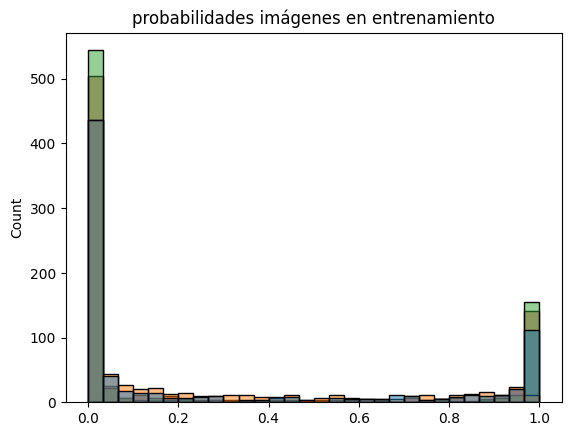

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

####probabilidades en evaluación para grupo 1 (tienen neumonía) #######
prob=modelo_ganador.predict(x_test_balanced)
sns.histplot(prob, legend=False, bins=30)
plt.title("probabilidades imágenes en entrenamiento")### conocer el comportamiento de las probabilidades para revisar threshold


In [1]:
### probabilidades en entrenamiento #####
prob=modelo_ganador.predict(x_train_balanced)
sns.histplot(prob, legend=False, bins=30)
plt.title("probabilidades imágenes en entrenamiento")### conocer el comportamiento de las probabilidades para revisar threshold


NameError: name 'modelo_ganador' is not defined

In [2]:
threshold_neu=0.95

pred_train=(modelo_ganador.predict(x_train_balance)>=threshold_neu).astype('int')
print(metrics.classification_report(y_train_balanced, pred_train))
cm=metrics.confusion_matrix(y_train_balanced,pred_train, labels=[0,1,2,3])
disp=metrics.ConfusionMatrixDisplay(cm,display_labels=['glioma', 'meningioma','pituitary','notumor'])
disp.plot()


threshold_neu=0.95

pred_test=(modelo_ganador.predict(x_test_balanced)>=threshold_neu).astype('int')
print(metrics.classification_report(y_test_balanced, pred_test))
cm=metrics.confusion_matrix(y_test_balanced,pred_test, labels=[0,1,2,3])
disp=metrics.ConfusionMatrixDisplay(cm,display_labels=['glioma', 'meningioma','pituitary','notumor'])
disp.plot()

NameError: name 'modelo_ganador' is not defined